In [2]:
import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from src.data.utils import erode, tophat, otsu, dilate, bbox, get_filename

In [3]:
# Download collection
# !python ../src/data/make_dataset.py ../data/raw ../data/processed

In [4]:
df = pd.read_csv('../data/processed/collection_details.csv', keep_default_na=False)
print(df.shape)
df.sample(3, random_state=42)

(3744, 28)


ID1 LeftRight  Age  number abnormality classification  \
3399  D2-0581         L   41       2        mass      Malignant   
1114  D1-0839         L   48       2        mass         Benign   
351   D1-0255         L   51       2        both         Benign   

              subtype                                           filepath  \
3399  triple negative  ./data/raw/1.3.6.1.4.1.14519.5.2.1.1239.1759.3...   
1114                   ./data/raw/1.3.6.1.4.1.14519.5.2.1.1239.1759.2...   
351                    ./data/raw/1.3.6.1.4.1.14519.5.2.1.1239.1759.3...   

     AcquisitionDate  BitsAllocated  ...  PatientName PatientOrientation  \
3399      2011-07-18              8  ...      D2-0581         ['A', 'R']   
1114      2010-07-18              8  ...      D1-0839        ['A', 'FR']   
351       2011-07-18              8  ...      D1-0255        ['A', 'FR']   

                                         SOPInstanceUID  SeriesDate  \
3399  1.3.6.1.4.1.14519.5.2.1.1239.1759.292049110335...  2011-07-18   
1114  1.3.6.1.4.1.14519.5.2.1.1239.1759.314875751804...  2010-07-18   
351   1.3.6.1.4.1.14519.5.2.1.1239.1759.289563003438...  2011-07-18   

                                      SeriesInstanceUID   StudyDate  \
3399  1.3.6.1.4.1.14519.5.2.1.1239.1759.316824088083...  2011-07-18   
1114  1.3.6.1.4.1.14519.5.2.1.1239.1759.239896716327...  2010-07-18   
351   1.3.6.1.4.1.14519.5.2.1.1239.1759.363500330730...  2011-07-18   

                                       StudyInstanceUID  \
3399  1.3.6.1.4.1.14519.5.2.1.1239.1759.894657584541...   
1114  1.3.6.1.4.1.14519.5.2.1.1239.1759.245202889496...   
351   1.3.6.1.4.1.14519.5.2.1.1239.1759.178558626231...   

                                       ViewCodeSequence WindowCenter  \
3399  [(0008, 0100) Code Value                      ...          128   
1114  [(0008, 0100) Code Value                      ...          128   
351   [(0008, 0100) Code Value                      ...          128   

     WindowWidth  
3399         256  
1114         256  
351          256  

[3 rows x 28 columns]

In [5]:
abnormality = 'calcification'
subset = df.loc[df['abnormality']==abnormality]
print(f'There are {subset.shape[0]} images with {abnormality} from {subset["ID1"].nunique()} patients')

There are 524 images with calcification from 241 patients


#### Patients with more than 2 images

In [6]:
np.random.seed(42)
two_breasts = subset.loc[subset['ID1'].isin(subset.groupby('ID1').size().index[subset.groupby('ID1').size()!=2])]
two_breasts[two_breasts['ID1'].isin(np.random.choice(two_breasts.ID1.unique(), 1, replace=False))]

ID1 LeftRight  Age  number    abnormality classification subtype  \
40  D1-0021         L   22       2  calcification         Benign           
41  D1-0021         L   22       2  calcification         Benign           
42  D1-0021         R   22       2  calcification         Benign           
43  D1-0021         R   22       2  calcification         Benign           

                                             filepath AcquisitionDate  \
40  ./data/raw/1.3.6.1.4.1.14519.5.2.1.1239.1759.8...      2010-07-18   
41  ./data/raw/1.3.6.1.4.1.14519.5.2.1.1239.1759.8...      2010-07-18   
42  ./data/raw/1.3.6.1.4.1.14519.5.2.1.1239.1759.8...      2010-07-18   
43  ./data/raw/1.3.6.1.4.1.14519.5.2.1.1239.1759.8...      2010-07-18   

    BitsAllocated  ...  PatientName PatientOrientation  \
40              8  ...      D1-0021        ['A', 'FR']   
41              8  ...      D1-0021         ['A', 'R']   
42              8  ...      D1-0021         ['P', 'L']   
43              8  ...      D1-0021        ['P', 'FL']   

                                       SOPInstanceUID  SeriesDate  \
40  1.3.6.1.4.1.14519.5.2.1.1239.1759.113975766086...  2010-07-18   
41  1.3.6.1.4.1.14519.5.2.1.1239.1759.688928500915...  2010-07-18   
42  1.3.6.1.4.1.14519.5.2.1.1239.1759.280869537978...  2010-07-18   
43  1.3.6.1.4.1.14519.5.2.1.1239.1759.186295882552...  2010-07-18   

                                    SeriesInstanceUID   StudyDate  \
40  1.3.6.1.4.1.14519.5.2.1.1239.1759.817188338697...  2010-07-18   
41  1.3.6.1.4.1.14519.5.2.1.1239.1759.817188338697...  2010-07-18   
42  1.3.6.1.4.1.14519.5.2.1.1239.1759.817188338697...  2010-07-18   
43  1.3.6.1.4.1.14519.5.2.1.1239.1759.817188338697...  2010-07-18   

                                     StudyInstanceUID  \
40  1.3.6.1.4.1.14519.5.2.1.1239.1759.620648341355...   
41  1.3.6.1.4.1.14519.5.2.1.1239.1759.620648341355...   
42  1.3.6.1.4.1.14519.5.2.1.1239.1759.620648341355...   
43  1.3.6.1.4.1.14519.5.2.1.1239.1759.620648341355...   

                                     ViewCodeSequence WindowCenter WindowWidth  
40  [(0008, 0100) Code Value                      ...          128         256  
41  [(0008, 0100) Code Value                      ...          128         256  
42  [(0008, 0100) Code Value                      ...          128         256  
43  [(0008, 0100) Code Value                      ...          128         256  

[4 rows x 28 columns]

In [7]:
# nrow,ncol = 3,3 
# fig, axs = plt.subplots(nrow, ncol, figsize=(1914/100,2294/100))
# for i, (idx, row) in enumerate(subset.sample(9, replace=False, random_state=42).iterrows()):
#     ax = axs.flatten()[i]
#     img = pydicom.dcmread('.'+row['filepath']).pixel_array
#     ax.axis('off')
#     ax.set_title(' '.join(get_filename(row).split('_')), color='red', size=18)
#     ax.imshow(img, cmap='Greys_r')
# # plt.axis('off');
# plt.subplots_adjust(wspace=0, hspace=0.07)
# plt.show()

### Plot malignants w/ mol. subtype

In [8]:
# nrow,ncol = 3, 3 
# fig, axs = plt.subplots(nrow, ncol, figsize=(fig_w,fig_h))
# subset_ = subset[subset['subtype']!=''].sample(nrow*ncol, replace=False, random_state=42)
# for i, (idx, row) in enumerate(subset_.iterrows()):
#     ax = axs.flatten()[i]
#     img = pydicom.dcmread('.'+row['filepath']).pixel_array
#     ax.axis('off')
#     ax.set_title(' '.join(get_filename(row).split('_')), color='red', size=18)
#     ax.imshow(img, cmap='Greys_r')
# # plt.axis('off');
# plt.subplots_adjust(wspace=0, hspace=0.07)
# plt.show()

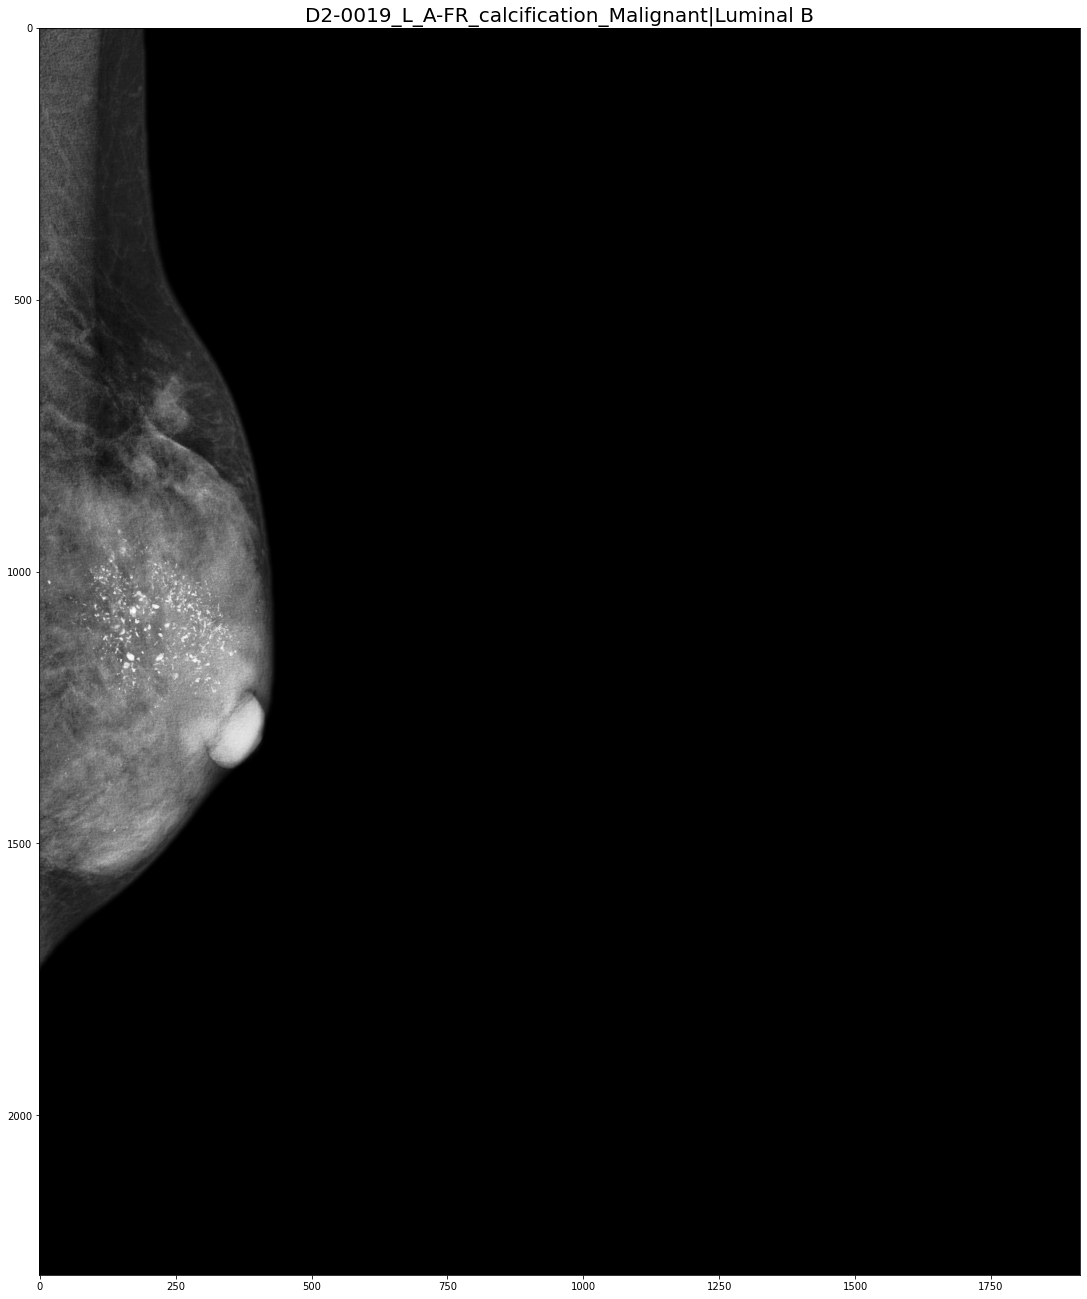

In [9]:
mol = subset[subset['subtype']!='']
row = mol.sample(1, random_state=42424242).iloc[0]
title = get_filename(row)
img = pydicom.dcmread('.' + row['filepath']).pixel_array.astype(np.uint8)
dpi=100
fig_h,fig_w = map(lambda x: x/100, [*img.shape])
# height, width = img.shape
plt.figure(figsize=(fig_w, fig_h))
plt.imshow(img, cmap='Greys_r');
plt.title(title, size=20);

In [10]:
def plot(row):
    img = pydicom.dcmread('.' + row['filepath']).pixel_array.astype(np.uint8)
    cv2.imshow(get_filename(row), img)
    cv2.waitKey(1)
    
row = subset.sample(9, replace=False, random_state=42).iloc[3]
# plot(row)

## Define calcification bounding box

![alt text](paper_segmentation.png "Method from paper 'Breast Microcalcification..'")

In [11]:
row = subset[subset['ID1']=='D1-0010'].iloc[1]
img = pydicom.dcmread('.' + row['filepath']).pixel_array.astype(np.uint8)

### Step 1 - erosion
"We firstly applied morphological erosion to a structure element **radius of 100 pixels** to remove the pixels close to the breast outline."

CODE  
```cv2.erode(image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(radius*2, radius*2))```

In [12]:
radius = 100 * 2 
erosion_struct = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(radius, radius))
# plt.imshow(erosion_struct, cmap='Greys_r');

In [13]:
eroded_img = erode(img, ksize=(radius, radius))
# erosion_mask = eroded_img != 0
erosion_mask = eroded_img > 0
image_erosion = img.copy()
image_erosion *= erosion_mask

In [14]:
# plt.figure(figsize=(19.14, 22.94))
# plt.imshow(eroded_img, cmap='Greys_r');
# plt.title(f'EROSION (kernel size={(radius, radius)}) - ' + title, size=20);

(-0.5, 1913.5, 2293.5, -0.5)

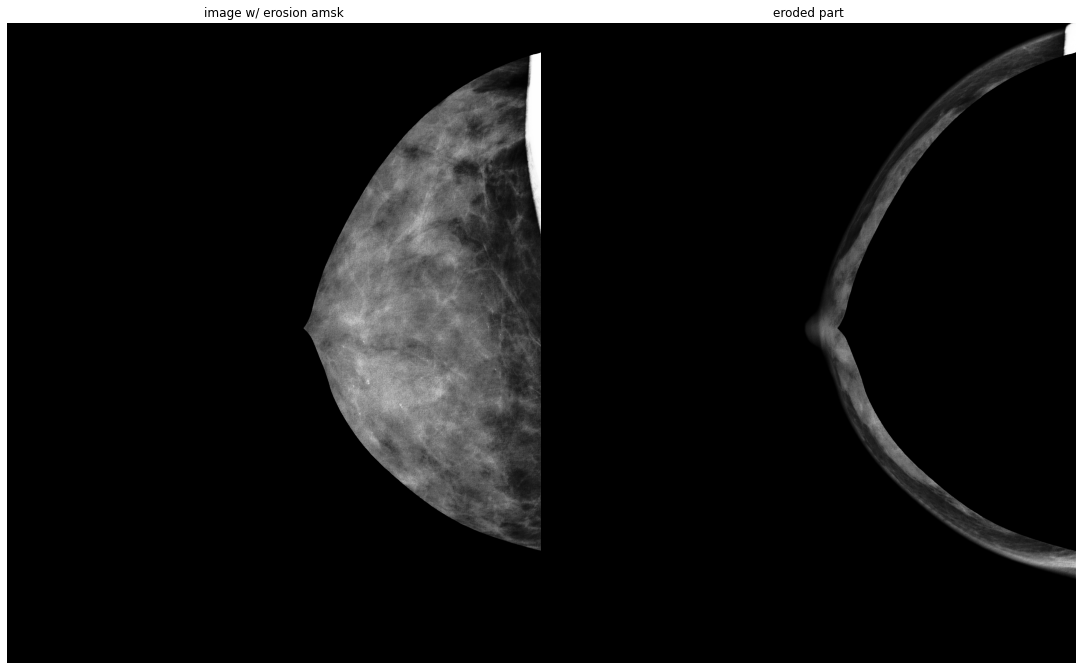

In [15]:
fig = plt.figure(figsize=(19.14, 22.94))
plt.subplots_adjust(wspace=0, hspace=0.07)

# ax = fig.add_subplot(221)
# ax.imshow(eroded_img, cmap='Greys_r');
# ax.set_title(f'EROSION (kernel size={(radius, radius)}) - ' + title,);
# ax.axis('off')

# ax = fig.add_subplot(131)
# ax.imshow(erosion_mask)
# ax.set_title(f'EROSION mask');
# ax.axis('off')

ax = fig.add_subplot(121)
ax.imshow(image_erosion, cmap='Greys_r')
ax.set_title(f'image w/ erosion amsk' );
ax.axis('off')

img_ = img.copy()
img_[erosion_mask] = 0
ax = fig.add_subplot(122)
ax.imshow(img_, cmap='Greys_r');
ax.set_title(f'eroded part');
ax.axis('off')

#### Find white blobs at borders/corners

In [47]:
2294*1914/100

43907.16

In [50]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

params.filterByColor = False  # may be broken
# Change thresholds
# params.minThreshold = 0
# params.maxThreshold = 50;

# Filter by Area.
params.filterByArea = True
params.minArea = 2294*1914/1000
params.maxArea = 2294*1914/10

# # Filter by Circularity
# params.filterByCircularity = True
# params.minCircularity = 0.1
# 
# # Filter by Convexity
# params.filterByConvexity = True
# params.minConvexity = 0.87
# 
# # Filter by Inertia
# params.filterByInertia = True
# params.minInertiaRatio = 0.01

# Create a detector with the parameters
detector = cv2.SimpleBlobDetector_create(params)
    
# Set up the detector with default parameters.
# detector = cv2.SimpleBlobDetector()

# Detect blobs.
keypoints = detector.detect(img)

In [51]:
keypoints

[]

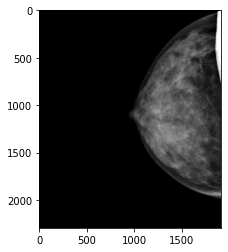

In [27]:
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(im_with_keypoints)

In [ ]:
# Set up the detector with default parameters.
detector = cv2.SimpleBlobDetector()

# Detect blobs.
keypoints = detector.detect(img)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show keypoints
cv2.imshow("Keypoints", im_with_keypoints)
cv2.waitKey(0)

## Step 2 - Top hat
"Then a morphological top-hat filtering with a **ball structural element** with a radius of 8 and a height of 100 pixels was applied."

CODE  
```cv2.morphologyEx(image, cv2.MORPH_TOPHAT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(rad*2, rad*2))```

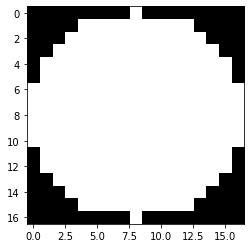

In [57]:
tophat_ksize = (17,17) 
tophat_struct = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=tophat_ksize)
plt.imshow(tophat_struct, cmap='Greys_r');

In [58]:
tophat_img = tophat(eroded_img, ksize=tophat_ksize)
image_tophat = tophat(image_erosion, ksize=tophat_ksize)
image_tophat_ = tophat(img, ksize=tophat_ksize)

(-0.5, 1913.5, 2293.5, -0.5)

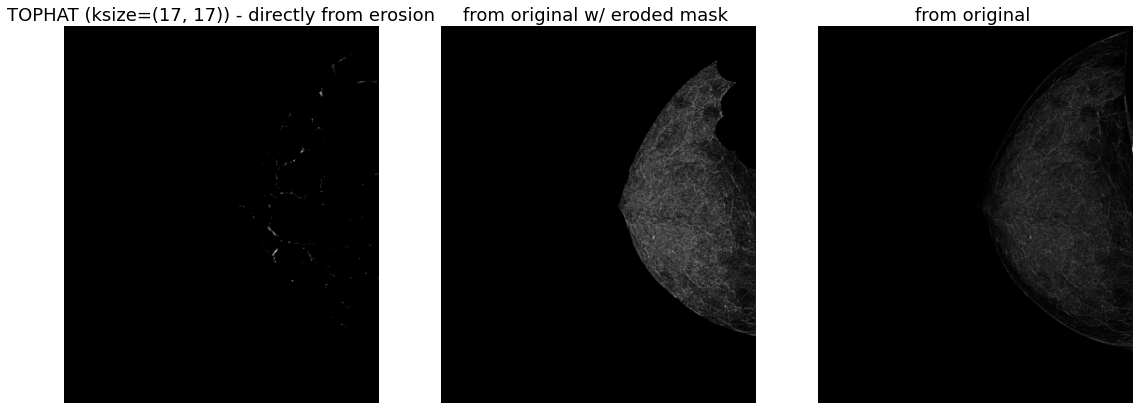

In [59]:
fig = plt.figure(figsize=(19.14, 22.94))
ax = fig.add_subplot(131)
ax.imshow(tophat_img, cmap='Greys_r');
ax.set_title(f'TOPHAT (ksize={tophat_ksize}) - directly from erosion', size=18);
ax.axis('off')

ax = fig.add_subplot(132)
ax.imshow(image_tophat, cmap='Greys_r');
ax.set_title(f'from original w/ eroded mask ', size=18);
ax.axis('off')

ax = fig.add_subplot(133)
ax.imshow(image_tophat_, cmap='Greys_r');
ax.set_title(f'from original ', size=18);
ax.axis('off')

## Step 3 - OTSU
"The resulting grayscale image was converted into a binary image by Otsu thresholding."

In [68]:
# OTSU
threshold_otsu, mask_otsu = cv2.threshold(image_tophat, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Manual
quantile = .99999
lb = np.quantile(image_tophat, quantile)
threshold, mask = cv2.threshold(image_tophat, lb, 255,cv2.THRESH_BINARY)
# print(f'Threshold found by OTSU: {threshold_otsu}')
# print(f'Quantile ({quantile}) threshold: {threshold}')

(-0.5, 1913.5, 2293.5, -0.5)

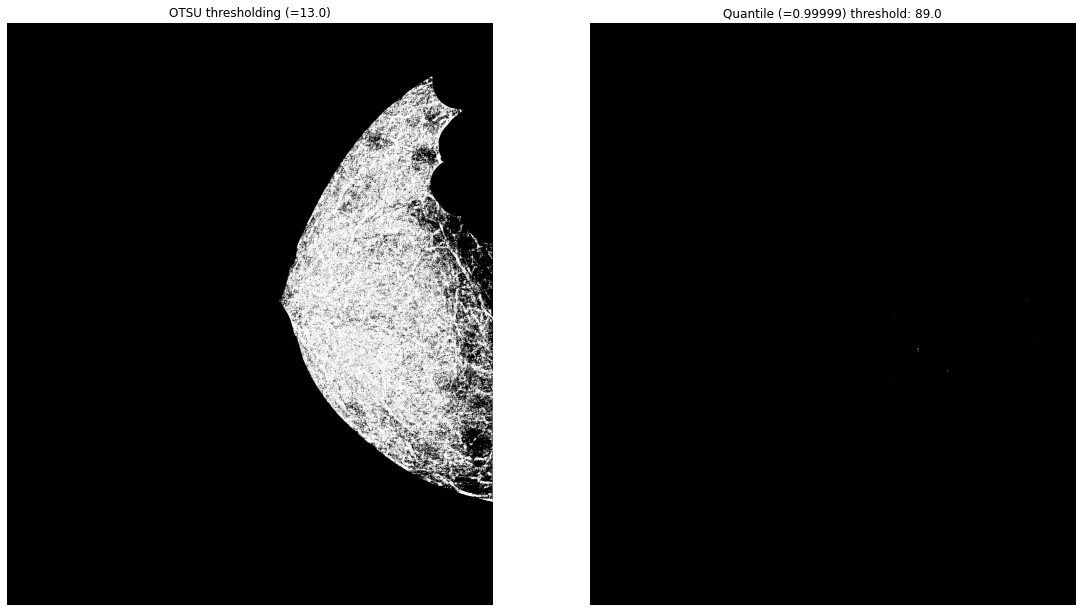

In [69]:
fig = plt.figure(figsize=(19.14, 22.94))
ax = fig.add_subplot(121)
ax.imshow(mask_otsu, cmap='Greys_r')
ax.set_title(f'OTSU thresholding (={threshold_otsu})')
ax.axis('off')

ax = fig.add_subplot(122)
ax.imshow(mask, cmap='Greys_r')
ax.set_title(f'Quantile (={quantile}) threshold: {threshold}')
ax.axis('off')

## Step 4 - mask dilatation
"The binary image was finally dilated with a **disk-shaped** structural element with a radius of 100 pixels"

CODE  
```cv2.dilate(mask, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(x,y))```

In [73]:
dilatation_radius = 100 * 2
dilate_ksize = (dilatation_radius, dilatation_radius)

dilatated_otsu = dilate(mask_otsu, dilate_ksize)
dilatated_mask = dilate(mask, dilate_ksize)

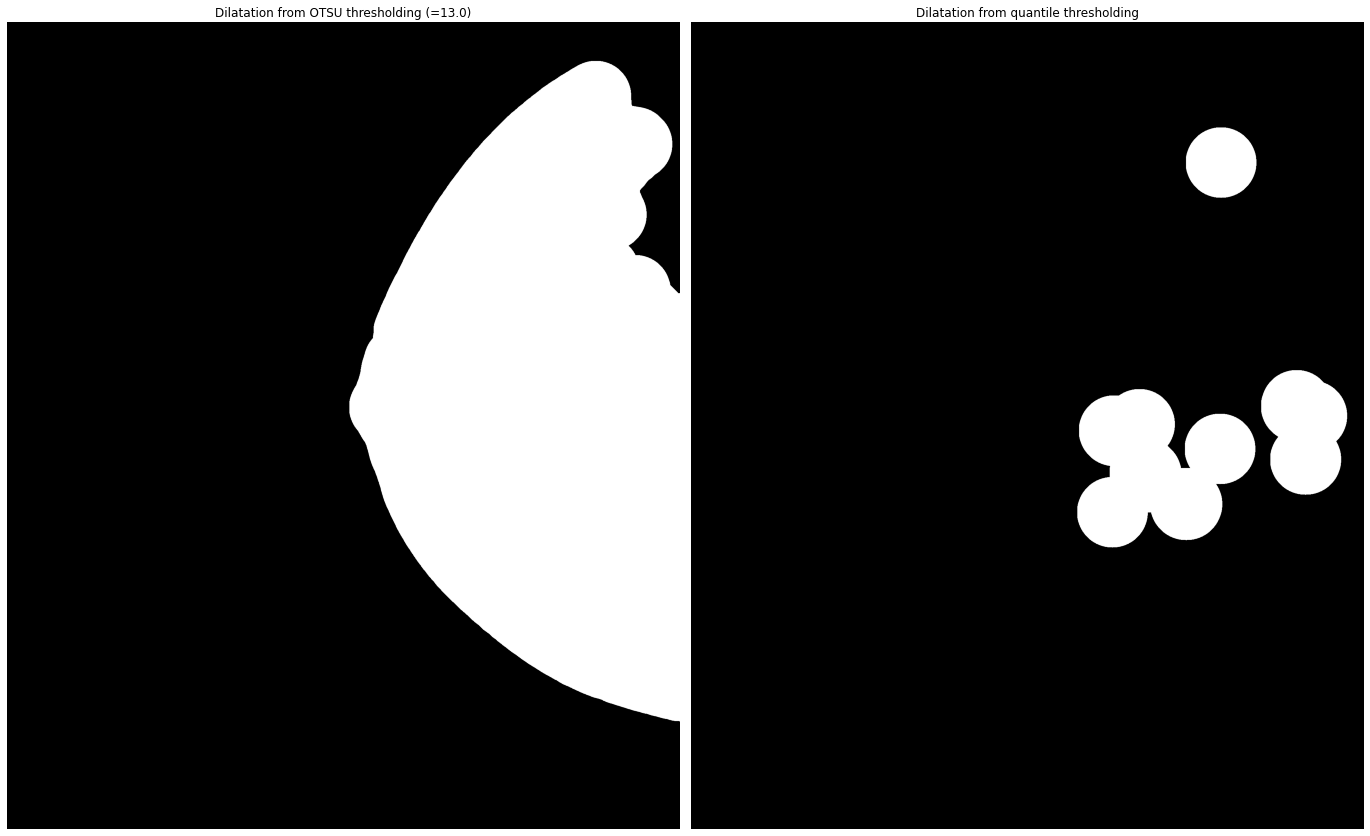

In [74]:
fig = plt.figure(figsize=(19.14, 22.94))
ax = fig.add_subplot(121)
ax.imshow(dilatated_otsu, cmap='Greys_r')
ax.set_title(f'Dilatation from OTSU thresholding (={threshold_otsu})')
ax.axis('off')

ax = fig.add_subplot(122)
ax.imshow(dilatated_mask, cmap='Greys_r')
ax.set_title(f'Dilatation from quantile thresholding')
ax.axis('off')
fig.tight_layout()
#fig.suptitle(f'Dilatation ksize={dilate_ksize}')
#fig.subplots_adjust(top=0.88)

Text(0.5, 1.0, 'BB from quantile thresholding')

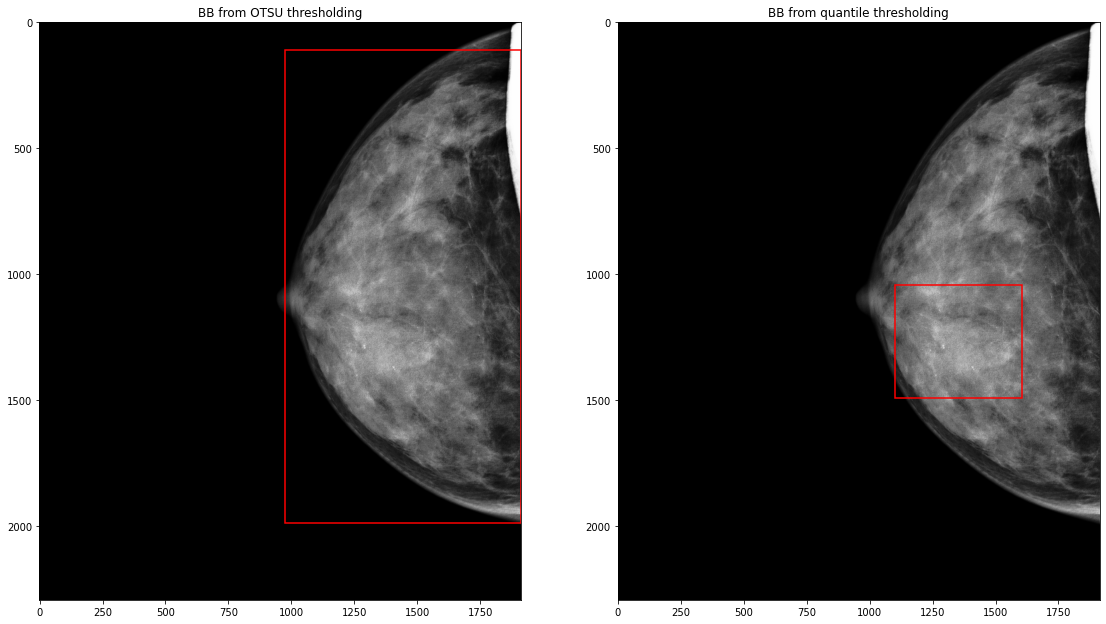

In [75]:
from matplotlib.patches import Rectangle

f, axes = plt.subplots(1, 2, figsize=(19, 22))

roi_o = bbox(dilatated_otsu)
roi_o = Rectangle((roi_o[0], roi_o[2]), roi_o[1]-roi_o[0], roi_o[3]-roi_o[2], 
                linewidth=1.5, edgecolor='r', facecolor='none') 

roi = bbox(dilatated_mask)
roi = Rectangle((roi[0], roi[2]), roi[1]-roi[0], roi[3]-roi[2], 
                linewidth=1.5, edgecolor='r', facecolor='none')  


axes[0].imshow(img, cmap='Greys_r')
axes[0].add_patch(roi_o)
axes[0].set_title('BB from OTSU thresholding')

axes[1].imshow(img, cmap='Greys_r')
axes[1].add_patch(roi)
axes[1].set_title('BB from quantile thresholding')

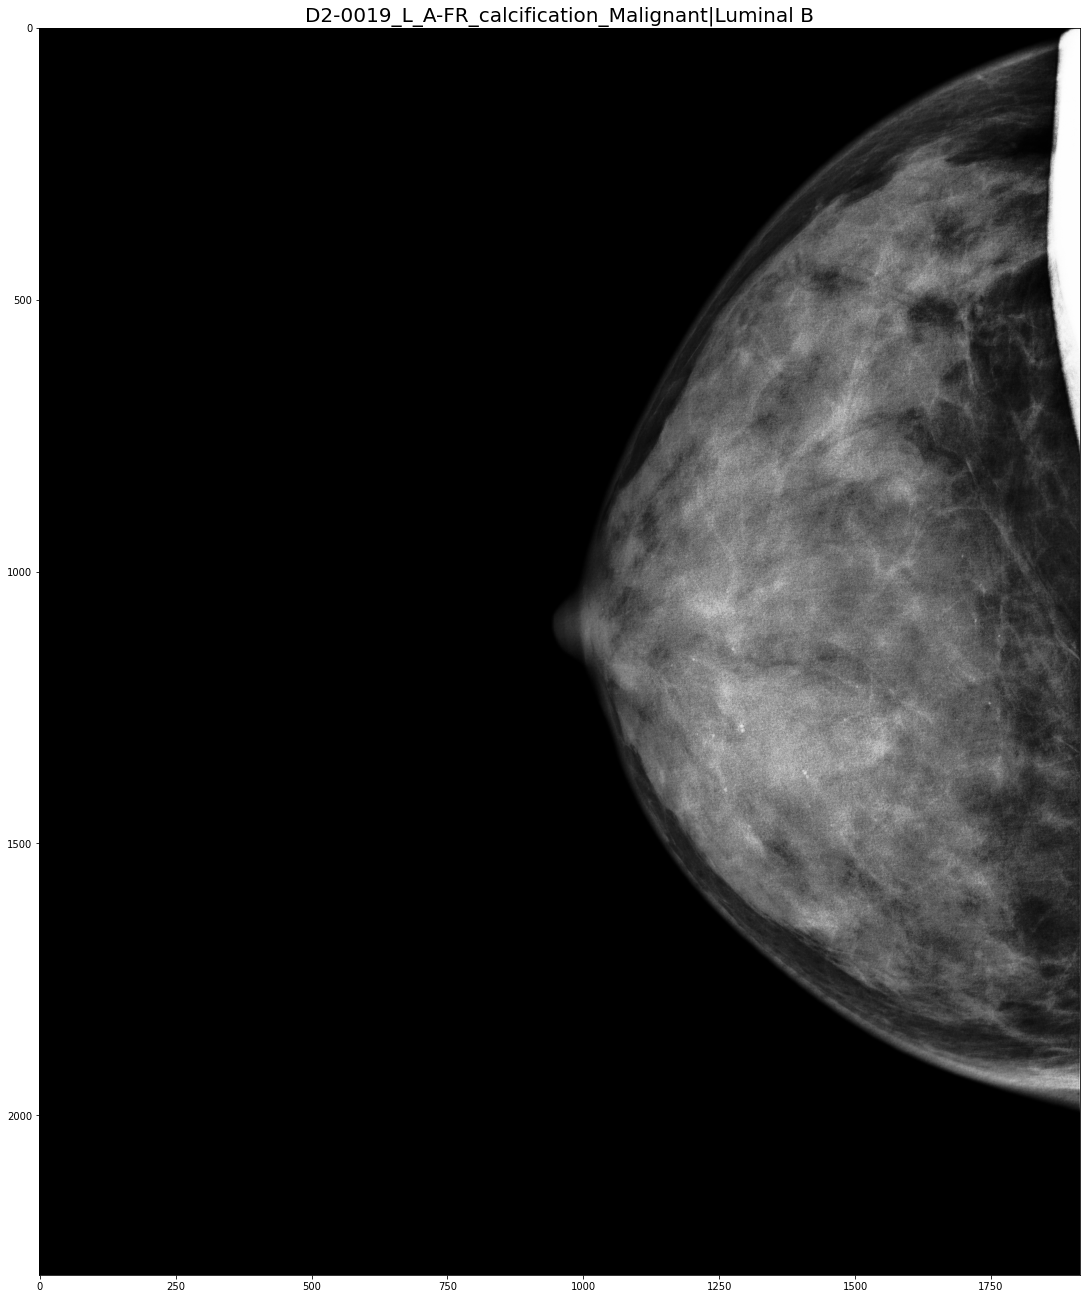

In [23]:
height, width = img.shape
plt.figure(figsize=(width / float(dpi), height / float(dpi)))
plt.imshow(img, cmap='Greys_r');
plt.title(title, size=20);

In [79]:
erosion_ksize=(200,200)
tophat_ksize=(17,17)
dilatation_ksize=(200,200)
threshold=.99999
threshold='OTSU'

In [80]:
from src.data.utils import identify_bbox, identify_bbox_v2

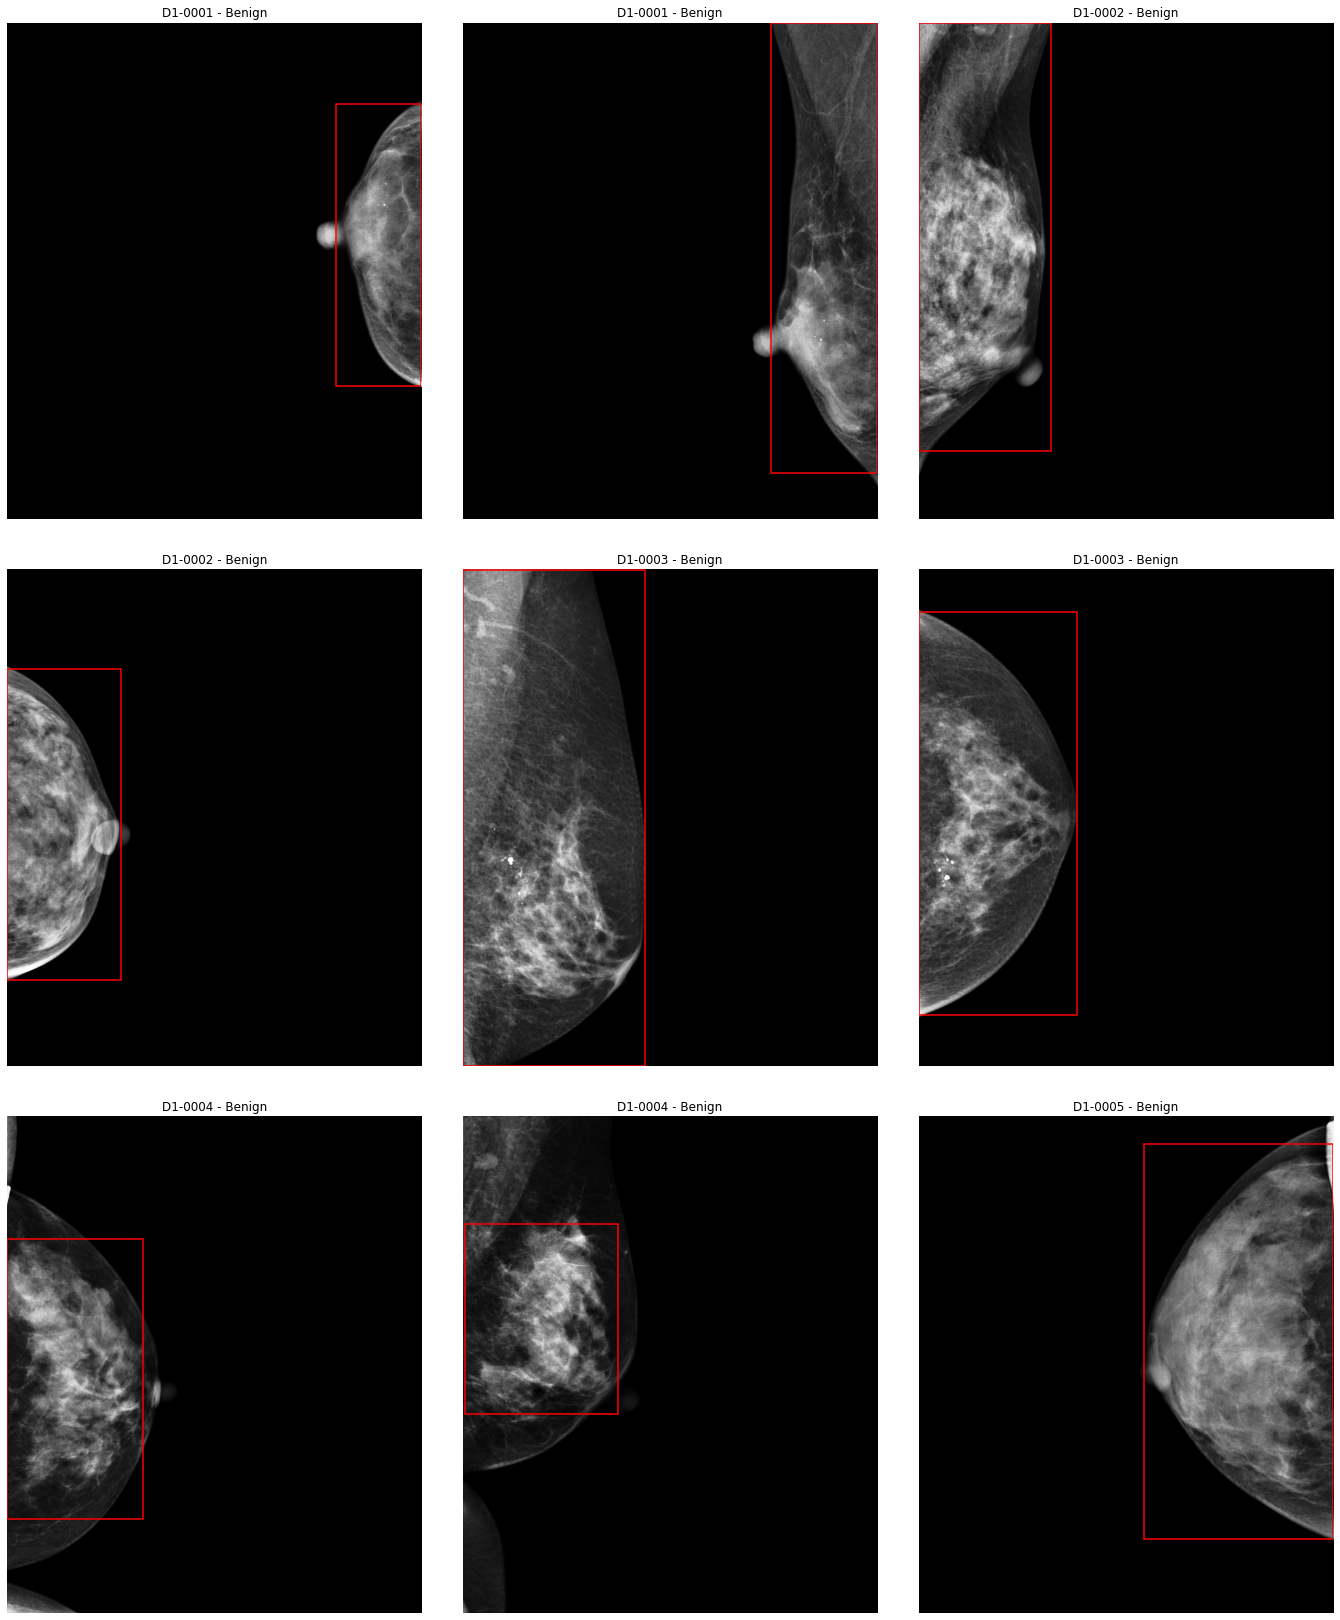

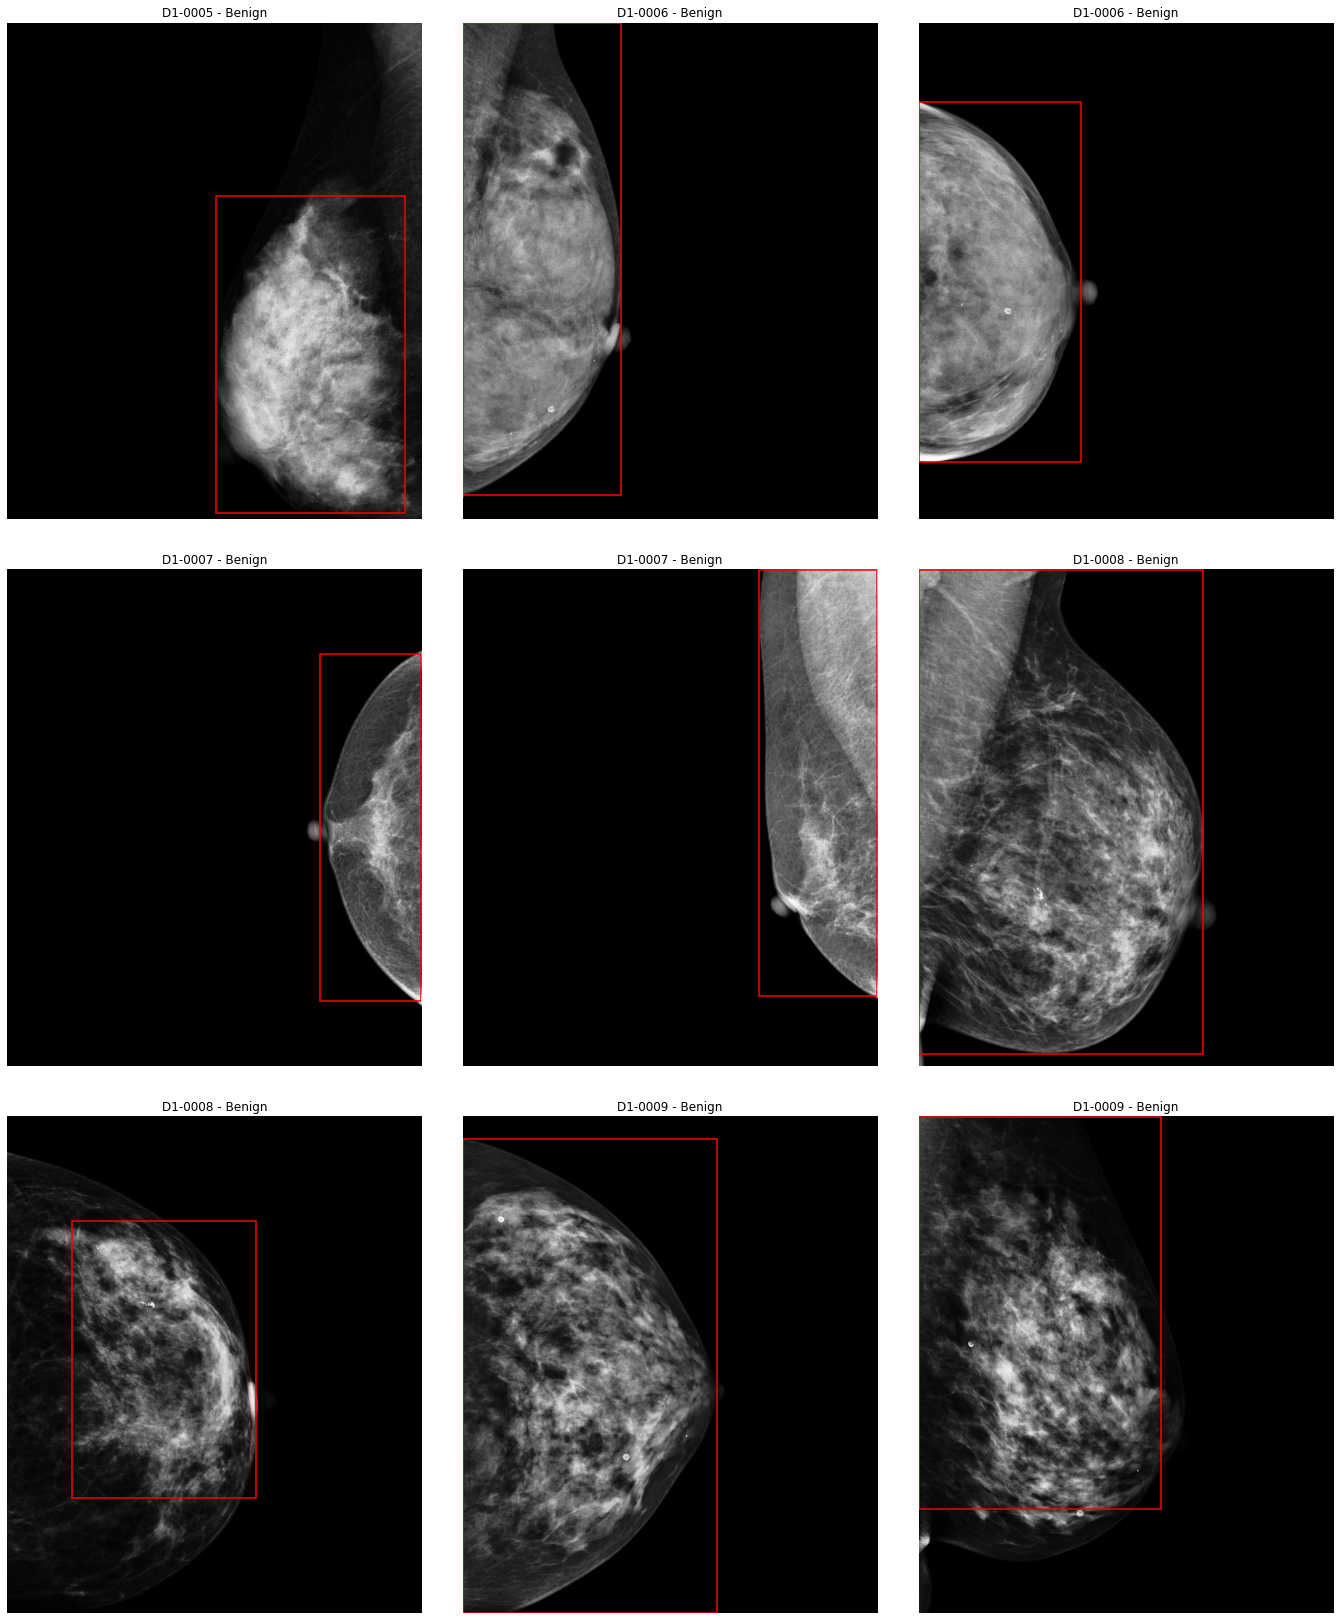

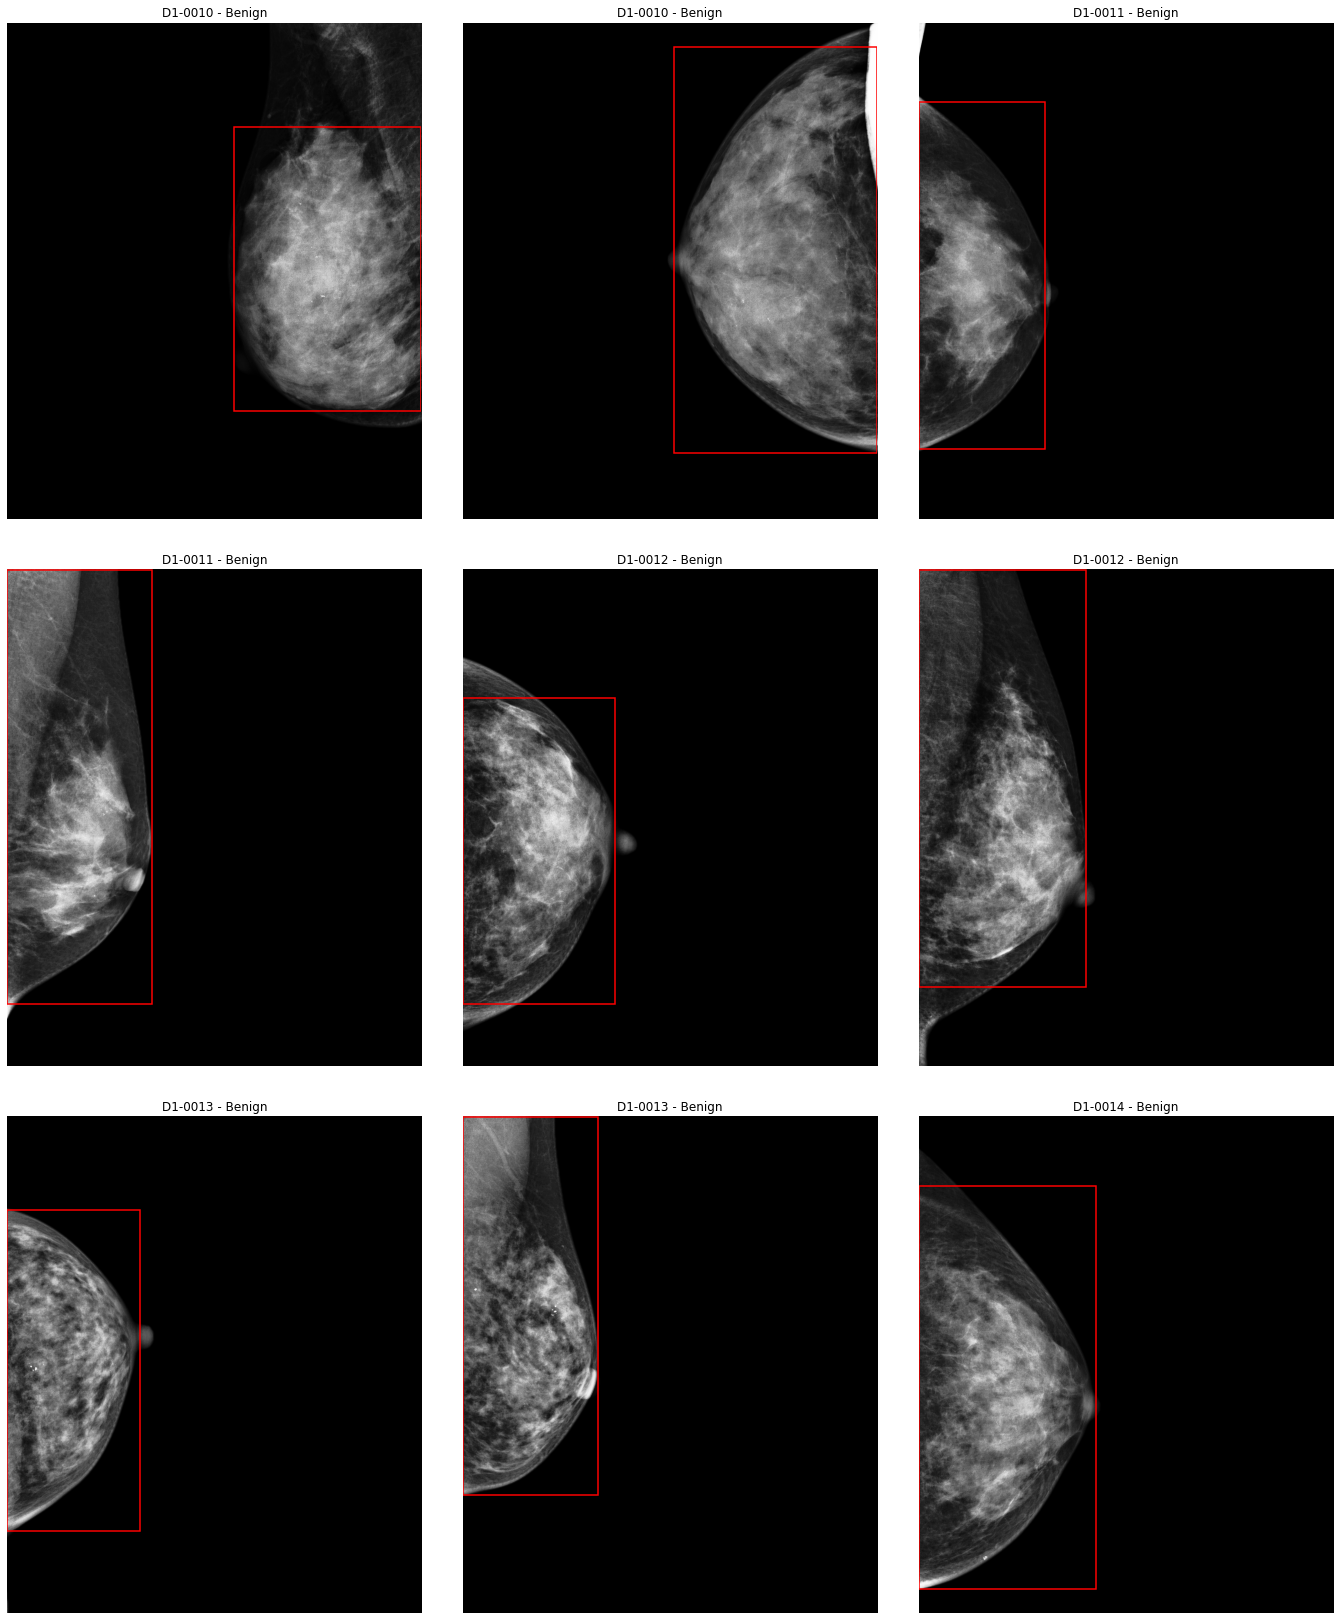

In [81]:
start_idx = 0
n_plots = 3
plots_per_figure = 9
for _ in range(n_plots):
    subset_ = subset.iloc[start_idx:start_idx+plots_per_figure]

    folder_name = f'erosion={erosion_ksize}_tophat={tophat_ksize}_threshold={threshold}_dilatation={dilatation_ksize}'
    folder_path = f'../reports/figures/{folder_name}'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plot_fname = f'{start_idx:03}-{start_idx+9}.png'
    plot_fp = os.path.join(folder_path, plot_fname)
    if os.path.exists(plot_fp):
        print(f'skipping plot {plot_fname} as it already exists')
        continue
    
    fig, axes = plt.subplots(3, 3, figsize=(19.14, 22.94))
    fig.tight_layout()
    axes = axes.flatten()
    [ax.axis('off') for ax in axes]
    
    for i, (idx, row) in enumerate(subset_.iterrows()):
        image = pydicom.dcmread('.'+row['filepath']).pixel_array.astype(np.uint8)

        bb = identify_bbox_v2(image, threshold, erosion_ksize, tophat_ksize, dilatation_ksize)

        roi = Rectangle((bb[0], bb[2]), bb[1]-bb[0], bb[3]-bb[2], 
                          linewidth=1.5, edgecolor='r', facecolor='none') 

        axes[i%plots_per_figure].imshow(image, cmap='Greys_r')
        axes[i%plots_per_figure].add_patch(roi)
        axes[i%plots_per_figure].set_title(f"{row['ID1']} - {row['classification']}")
    
    plt.savefig(plot_fp)
    start_idx += i+1
    # ax.set_title('BB from quantile thresholding')